In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

Loading embeddings from all four directories...


100%|██████████| 512/512 [00:01<00:00, 496.49it/s]



Running t-SNE...
Plotting results...


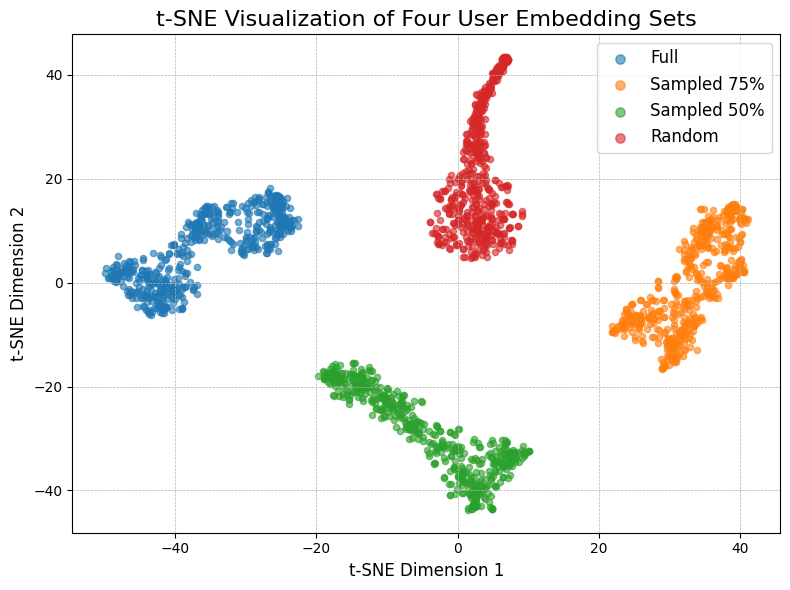

In [2]:
# 1. 경로 설정 (네 개의 디렉토리)
full_dir = "/root/sasrec_new/sports/user_repr_best"
sampled_dir_75 = "/root/sasrec_new/sports75/user_repr_best"
sampled_dir_50 = "/root/sasrec_new/sports50/user_repr"
random_dir = "/root/sasrec_new/sports_random/user_repr"

# 2. 각 임베딩을 저장할 리스트 초기화
full_embeddings = []
sampled_75_embeddings = []
sampled_50_embeddings = []
random_embeddings = []
user_ids = []

# 기준이 되는 디렉토리의 파일 목록 가져오기
user_files = sorted(os.listdir(full_dir))

print("Loading embeddings from all four directories...")
# 3. 모든 디렉토리에서 공통으로 존재하는 사용자의 임베딩 로드
for fname in tqdm(user_files):
    # 각 디렉토리의 파일 경로 생성
    full_path = os.path.join(full_dir, fname)
    sampled_path_75 = os.path.join(sampled_dir_75, fname)
    sampled_path_50 = os.path.join(sampled_dir_50, fname)
    random_path = os.path.join(random_dir, fname)

    # 네 곳 모두에 파일이 존재하는지 확인
    if not all(os.path.exists(p) for p in [full_path, sampled_path_75, sampled_path_50, random_path]):
        continue

    # 파일 로드
    full_obj = torch.load(full_path, map_location="cuda:0", weights_only=False)
    sampled_obj_75 = torch.load(sampled_path_75, map_location="cuda:0", weights_only=False)
    sampled_obj_50 = torch.load(sampled_path_50, map_location="cuda:0", weights_only=False)
    random_obj = torch.load(random_path, map_location="cuda:0", weights_only=False)

    # 임베딩 벡터 추출 및 정규화
    full_vec = torch.nn.functional.normalize(full_obj["user_repr"].squeeze(0), dim=0)
    sampled_vec_75 = torch.nn.functional.normalize(sampled_obj_75["user_repr"].squeeze(0), dim=0)
    sampled_vec_50 = torch.nn.functional.normalize(sampled_obj_50["user_repr"].squeeze(0), dim=0)
    random_vec = torch.nn.functional.normalize(random_obj["user_repr"].squeeze(0), dim=0)

    # 각 리스트에 추가
    full_embeddings.append(full_vec.cpu().numpy())
    sampled_75_embeddings.append(sampled_vec_75.cpu().numpy())
    sampled_50_embeddings.append(sampled_vec_50.cpu().numpy())
    random_embeddings.append(random_vec.cpu().numpy())
    user_ids.append(fname.split(".")[0])

# 4. 네 개의 임베딩 리스트를 하나로 합치기
all_embeddings = np.vstack([
    full_embeddings,
    sampled_75_embeddings,
    sampled_50_embeddings,
    random_embeddings
])

# 5. 각 데이터 포인트에 대한 레이블 생성
labels_map = {
    "Full": len(full_embeddings),
    "Sampled 75%": len(sampled_75_embeddings),
    "Sampled 50%": len(sampled_50_embeddings),
    "Random": len(random_embeddings)
}
labels = []
for label, count in labels_map.items():
    labels.extend([label] * count)

print("\nRunning t-SNE...")
# 6. t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000, learning_rate='auto', init='pca')
tsne_result = tsne.fit_transform(all_embeddings)

print("Plotting results...")
# 7. 시각화
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # 색상 지정

for i, label in enumerate(labels_map.keys()):
    idx = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(
        tsne_result[idx, 0],
        tsne_result[idx, 1],
        label=label,
        alpha=0.6,
        s=20, # 점 크기 조절
        c=colors[i]
    )

plt.title("t-SNE Visualization of Four User Embedding Sets", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(fontsize=12, markerscale=1.5) # 범례 크기 조절
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [3]:
embeddings_to_compare = {
    "Sampled 75%": sampled_75_embeddings,
    "Sampled 50%": sampled_50_embeddings,
    "Random": random_embeddings
}

print("기준이 되는 Full 임베딩의 거리 행렬을 계산합니다...")
# 1. 기준(Full) 임베딩에 대해 cosine distance matrix 계산
dist_full = squareform(pdist(full_embeddings, metric="cosine"))

# 2. upper triangular part만 추출 (중복 및 대각 제외)
triu_indices = np.triu_indices_from(dist_full, k=1)
vec_full = dist_full[triu_indices]

print("-" * 50)

# 3. 나머지 세 개의 임베딩과 순차적으로 비교 및 상관계수 계산
for name, embeddings_other in embeddings_to_compare.items():
    print(f"Full 임베딩과 '{name}' 임베딩의 상관관계를 계산합니다...")

    # 비교 대상의 cosine distance matrix 계산
    dist_other = squareform(pdist(embeddings_other, metric="cosine"))

    # upper triangular part 추출
    vec_other = dist_other[triu_indices]

    # 상관계수 계산
    spearman_r, spearman_p = spearmanr(vec_full, vec_other)
    pearson_r, pearson_p = pearsonr(vec_full, vec_other)

    # 결과 출력
    print(f"  Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
    print(f"  Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")
    print("-" * 50)

기준이 되는 Full 임베딩의 거리 행렬을 계산합니다...
--------------------------------------------------
Full 임베딩과 'Sampled 75%' 임베딩의 상관관계를 계산합니다...
  Spearman correlation: r = 0.8430, p = 0
  Pearson correlation : r = 0.8496, p = 0
--------------------------------------------------
Full 임베딩과 'Sampled 50%' 임베딩의 상관관계를 계산합니다...
  Spearman correlation: r = 0.7204, p = 0
  Pearson correlation : r = 0.7336, p = 0
--------------------------------------------------
Full 임베딩과 'Random' 임베딩의 상관관계를 계산합니다...
  Spearman correlation: r = 0.1895, p = 0
  Pearson correlation : r = 0.2275, p = 0
--------------------------------------------------


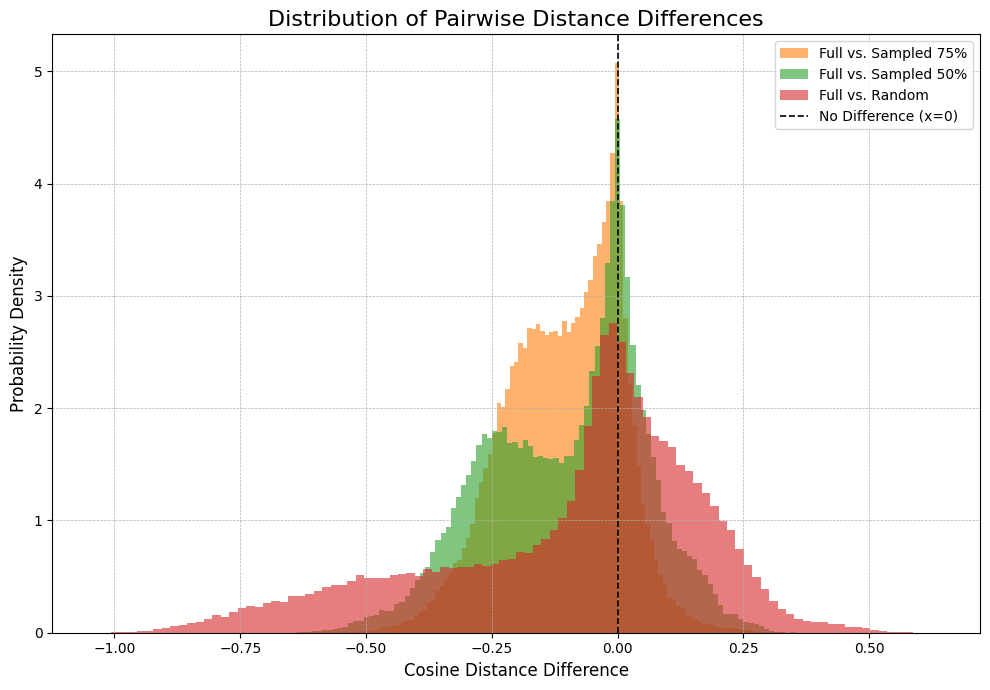

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# This assumes 'vec_full' and 'embeddings_to_compare' are already defined
# from the previous steps.

# Create a figure object for the plot
plt.figure(figsize=(10, 7))

# List of colors to use for the plots
colors = ['#ff7f0e', '#2ca02c', '#d62728'] # Corresponds to Sampled 75%, Sampled 50%, Random

# 1. Loop through the embeddings to calculate and plot the distribution of differences
for i, (name, embeddings_other) in enumerate(embeddings_to_compare.items()):
    # Calculate the cosine distance matrix and its upper triangular vector
    dist_other = squareform(pdist(embeddings_other, metric="cosine"))
    vec_other = dist_other[np.triu_indices_from(dist_other, k=1)]

    # Calculate the difference from the 'Full' vector
    difference = vec_full - vec_other

    # Plot the histogram
    plt.hist(
        difference,
        bins=100,
        alpha=0.6,
        label=f'Full vs. {name}',
        color=colors[i],
        density=True  # Use probability density to normalize the y-axis
    )

# 2. Set the graph title and labels in English
plt.title("Distribution of Pairwise Distance Differences", fontsize=16)
plt.xlabel("Cosine Distance Difference", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1.2, label='No Difference (x=0)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

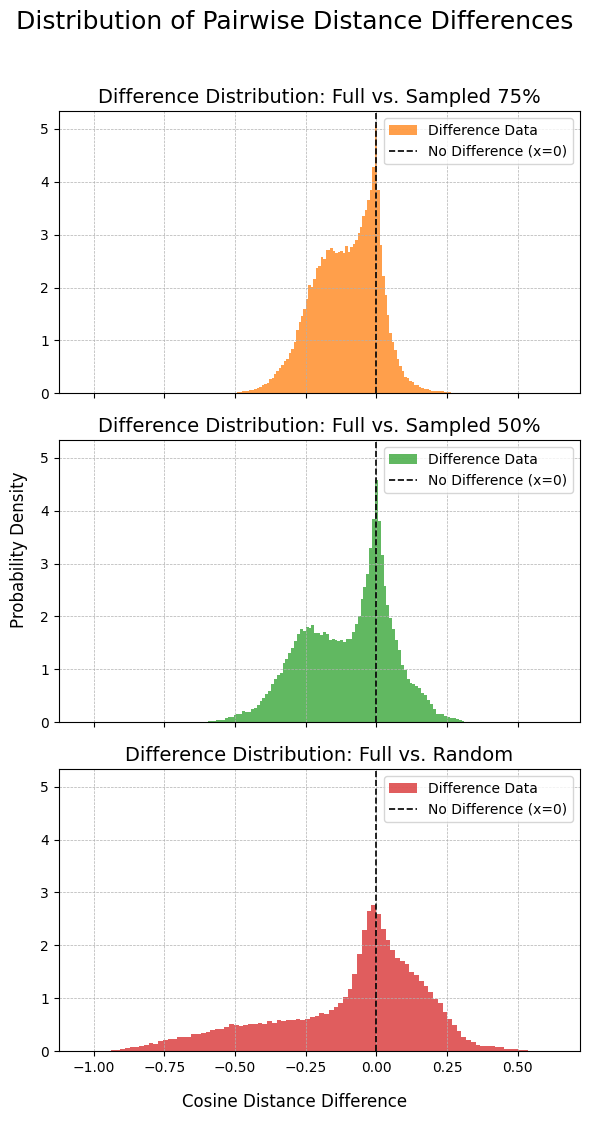

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# This assumes 'vec_full' and 'embeddings_to_compare' are already defined
# from the previous steps.

# Create a figure with 3 subplots stacked vertically
# sharex=True and sharey=True make the axes scales consistent for easier comparison
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration, although it's already 1D
axes = axes.flatten()

# List of colors to use for the plots
colors = ['#ff7f0e', '#2ca02c', '#d62728'] # Corresponds to Sampled 75%, Sampled 50%, Random

# 1. Loop through the embeddings and the subplots (axes) simultaneously
for i, (ax, (name, embeddings_other)) in enumerate(zip(axes, embeddings_to_compare.items())):
    # Calculate the cosine distance matrix and its upper triangular vector
    dist_other = squareform(pdist(embeddings_other, metric="cosine"))
    vec_other = dist_other[np.triu_indices_from(dist_other, k=1)]

    # Calculate the difference from the 'Full' vector
    difference = vec_full - vec_other

    # Plot the histogram on the current subplot 'ax'
    ax.hist(
        difference,
        bins=100,
        alpha=0.75,
        label=f'Difference Data', # Simple label for the legend
        color=colors[i],
        density=True
    )
    
    # Set the title and grid for each subplot
    ax.set_title(f"Difference Distribution: Full vs. {name}", fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a vertical line at x=0
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1.2, label='No Difference (x=0)')
    ax.legend()

# Set common labels for the shared axes to avoid repetition
fig.text(0.5, 0.04, 'Cosine Distance Difference', ha='center', va='center', fontsize=12)
fig.text(0.04, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical', fontsize=12)

# Add a main title for the entire figure
fig.suptitle("Distribution of Pairwise Distance Differences", fontsize=18, y=0.95)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0.05, 0.05, 1, 0.93]) # Adjust rect to make space for suptitle
plt.show()

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# 이 코드는 'vec_full'과 'embeddings_to_compare' 딕셔너리가
# 이전 단계에서 이미 정의되었다고 가정합니다.

print("-" * 50)
# 반복문을 통해 각 임베딩과의 거리 차이 통계량 계산
for name, embeddings_other in embeddings_to_compare.items():
    print(f"Statistics for [Full vs. {name}]")

    # 비교 대상의 cosine distance matrix 및 벡터 계산
    dist_other = squareform(pdist(embeddings_other, metric="cosine"))
    vec_other = dist_other[np.triu_indices_from(dist_other, k=1)]

    # 기준(Full) 벡터와의 거리 차이 계산
    difference = vec_full - vec_other

    # 통계량 계산
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    max_abs_diff = np.max(np.abs(difference))
    
    # 절댓값 차이가 0.2 미만인 비율 계산
    # (np.abs(difference) < 0.2)는 boolean 배열을 반환하며,
    # 여기서 True는 1, False는 0으로 취급되므로 .mean()은 비율과 같습니다.
    proportion_small_diff = np.mean(np.abs(difference) < 0.2)

    # 결과 출력
    print(f"  Mean difference              : {mean_diff: .4f}")
    print(f"  Std. of difference           : {std_diff: .4f}")
    print(f"  Max absolute difference      : {max_abs_diff: .4f}")
    print(f"  Proportion (|diff| < 0.2)   : {proportion_small_diff:.2%}")
    print("-" * 50)

--------------------------------------------------
Statistics for [Full vs. Sampled 75%]
  Mean difference              : -0.1049
  Std. of difference           :  0.1133
  Max absolute difference      :  0.5532
  Proportion (|diff| < 0.2)   : 78.09%
--------------------------------------------------
Statistics for [Full vs. Sampled 50%]
  Mean difference              : -0.0995
  Std. of difference           :  0.1559
  Max absolute difference      :  0.6682
  Proportion (|diff| < 0.2)   : 70.04%
--------------------------------------------------
Statistics for [Full vs. Random]
  Mean difference              : -0.0902
  Std. of difference           :  0.2670
  Max absolute difference      :  1.0400
  Proportion (|diff| < 0.2)   : 63.18%
--------------------------------------------------
